In [502]:
import matplotlib as mpl
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import networkx as nx
import netwulf as nw
from itertools import combinations
from collections import defaultdict
import random
from scipy import stats
from networkx.algorithms import community
import community
import json
from tqdm import tqdm 
import os

seed = 1337
random.seed(seed)
np.random.seed(seed)

# Network
This section of the notebook will go through the network analysis of the data. We have used `networkx` to build the networks and `netwulf` to visualise them. The the following sections we will be investigating the full network of all musicians as well as a subset of them based on selected genres. The networks will be studied by calculating different statistics, such as number of nodes, number of links, density, clusterings and more. In addition, we will look at community detection to see how well the different genres manages to partition the networks into communities in comparison to the Louvain algorithm for community detection.

# Load data

In [503]:
song_data = pd.read_pickle('songData.df')
print(f'Number of songs: {len(song_data)}')

Number of songs: 25706


Network visualisation config.

In [504]:
with open('network_figures/config.txt') as f:
    data = f.read()
config = json.loads(data)

## Creating the full network
Calculate all genres associated to each artist as well as how many songs they have made for each genre.

In [505]:
all_artists = set()
artist_genres = dict()
artist_genres_count = defaultdict(lambda: defaultdict(lambda: 0))
for artists, genres in zip(song_data.artists, song_data.genres):
    for artist in artists:
        all_artists = all_artists.union(set([artist]))
        for genre in genres:
            artist_genres_count[artist][genre] += 1
        if artist in artist_genres.keys():
            artist_genres[artist] = artist_genres[artist].union(set(genres))
        else:
            artist_genres[artist] = set(genres)
        

all_artists = list(all_artists)
print(f'Number of unique artists: {len(all_artists)}')

Number of unique artists: 8079


Creating a list of 20 genres from which each artist can get their main genre label. In addition, a colour list to colour each node based on their main genre.

In [506]:
genre_list = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul', 'ballad', 'hip-hop', 
              'trap', 'singer-songwriter', 'funk', 'eighties', 'seventies', 'soundtrack',
              'dance', 'electronic', 'folk', 'cover', 'jazz', 'blues']

In [507]:
colour_list = ['#E74C3C', '#8E44AD', '#3498DB', '#2ECC71', '#F39C12', '#F1C40F', '#F5B7B1', '#5D6D7E', 
               '#AED6F1','#F5B7B1', '#FCF3CF', '#DCB9ED', '#8F2323', '#8F6A23', '#4F8F23', '#23628F', 
               '#6B238F', '#AED6F1','#A3E4D7', '#D4AC0D', '#D7BDE2']

In [508]:
genre_to_colour_dict = {}
for colour, genre in zip(colour_list, genre_list):
    genre_to_colour_dict[genre] = colour

Calculate number of songs each artist has in the data set as well as how many times they have collaborated with other artists.

In [509]:
artist_count = defaultdict(lambda: 0)
artist_colab_count = defaultdict(lambda: defaultdict(lambda: 0))

for artists in song_data.artists:
    for artist in artists:
        artist_count[artist] += 1
        for colab in artists:
            if colab != artist:
                artist_colab_count[artist][colab] += 1

### Add nodes
Add each artist as a node with three attributes
> *genre*: most common genre for that artist within the fixed list 'genre_list'

> *size*: number of times the artist has appeared on Billboard's the hot 100 (used to give each node the correct size)

> *all_genres*: all genres associated with that artist

> *group*: the colour of the genre associated with the artist

If an artist has multiple most common genres, meaning that they, e.g. have made 5 pop songs and 5 rock songs, the *genre* attribute for that artist will be picked at random amongst the most common genres. An exception for to is with _rap_ and _trap_, because trap is a subgenre of rap (but still a major and defined genre), we deem it more appropriate to label artists as _trap_, if they have an equal number of rap and trap songs.

In [510]:
G = nx.Graph()
for artist in all_artists:
    most_occurences = 0
    rap_count = 0
    trap_count = 0
    max_key = 'other'
    random.shuffle(genre_list)
    
    for genre in genre_list:
        if genre in artist_genres_count[artist]:
            if genre == 'rap':
                rap_count = artist_genres_count[artist][genre]
            if genre == 'trap':
                trap_count = artist_genres_count[artist][genre]             
            
            if artist_genres_count[artist][genre] > most_occurences:
                most_occurences = artist_genres_count[artist][genre]
                max_key = genre
                
    if (rap_count > 0) and (rap_count == trap_count) and (max_key in ['rap', 'trap']):
        max_key = 'trap'
    
    G.add_node(artist, 
               genre=max_key, 
               size=artist_count[artist], 
               all_genres=artist_genres[artist], 
               group=genre_to_colour_dict[max_key])
    
G.number_of_nodes()
print(f'Number of nodes: {G.number_of_nodes()}')

Number of nodes: 8079


### Add edges
Add edges between two artists if they have collaborated on a song and weigh the edge by the number of times they have collaborated.

In [511]:
linked_artists = set()
for artists in song_data.artists:
    if len(artists) > 1:
        for comb in combinations(artists, 2):
            if not comb[0] == comb[1]:
                linked_artists = linked_artists.union({tuple([comb[0], comb[1], artist_colab_count[comb[0]][comb[1]]])})

linked_artists = list(linked_artists)
G.add_weighted_edges_from(linked_artists)
print(f'Number of edges: {G.number_of_edges()}')

Number of edges: 7273


### Helper functions

In [512]:
def randomized_graph(graph, N):
    g = graph.copy()
    swaps = 0
    while swaps < N:
        uv = random.choice(list(g.edges()))
        if uv[0] == uv[1]:
            uv = random.choice(list(g.edges()))
        xy = random.choice(list(g.edges()))
        while uv[1] == xy[0]:
            xy = random.choice(list(g.edges()))
        if not g.has_edge(uv[0], xy[1]) and not g.has_edge(uv[1], xy[0]):
            g.remove_edges_from([uv, xy])
            g.add_edges_from([(uv[0], xy[1]), (uv[1], xy[0])])
            swaps += 1
    return g

In [513]:
def naive_randomized_graph(graph):
    g = nx.MultiGraph(graph)
    edges = list(g.edges())
    sources = [a for a, b in edges]
    targets = [b for a, b in edges]
    unique_list = sources + targets
    random.shuffle(unique_list)
    new_edges = [(unique_list[i], unique_list[i+1]) for i in range(0, len(unique_list)-1, 2)]
    g.remove_edges_from(edges)
    g.add_edges_from(new_edges)
    return g

In [514]:
def get_network_by_genre(G, genre):
    genre_nodes = [node for node, data in G.nodes(data=True) if genre in data['all_genres']]
    return G.subgraph(genre_nodes)

In [515]:
def get_partitioning(filtered_graph):
    partitioning = []
    nc = set(nx.get_node_attributes(filtered_graph, 'group').values())
    for i in nc:
        nodes = (
            node
            for node, data
            in filtered_graph.nodes(data=True)
            if data.get("group") == i
        )
        partitioning.append(filtered_graph.subgraph(nodes))
    return partitioning

In [516]:
def modularity(graph, partitioning):
    M = 0
    L = graph.number_of_edges()
    for subgraph in partitioning:
        Lc = subgraph.number_of_edges()
        kc = sum(graph.degree[node] for node in subgraph.nodes())
        M += Lc/L - (kc / (2 * L))**2
    return M

### Deciding which genre networks to analyse
It was previously decided that each artists could get their main label based on `genre_list`. Though, analysing and visualising 20 different networks can get a bit cumbersome, so we will be picking out a subset of these. To do this, we will first find out how many artists have each genre as their main genre, and also how many times each genre has occurred in total.

In [517]:
main_genre_sizes = defaultdict(lambda: 0)
for art, data in G.nodes(data=True):
    main_genre_sizes[data['genre']] += 1

In [518]:
all_genre_sizes = defaultdict(lambda: 0)
for art, data in G.nodes(data=True):
    for g in data['all_genres']:
        all_genre_sizes[g] += 1

In [519]:
{k: v for k, v in sorted(main_genre_sizes.items(), key=lambda item: item[1], reverse=True)}

{'pop': 3548,
 'rap': 1836,
 'rock': 940,
 'r&b': 640,
 'country': 377,
 'trap': 165,
 'soul': 95,
 'hip-hop': 88,
 'electronic': 66,
 'soundtrack': 65,
 'dance': 53,
 'singer-songwriter': 43,
 'eighties': 33,
 'funk': 27,
 'ballad': 26,
 'cover': 22,
 'folk': 19,
 'seventies': 15,
 'jazz': 14,
 'blues': 7}

In [520]:
_ = [print(x) for x in list({k: v for k, v in sorted(all_genre_sizes.items(), key=lambda item: item[1], reverse=True)}.items())[:25]]

('pop', 4922)
('rap', 2601)
('rock', 1826)
('r&b', 1641)
('soul', 725)
('ballad', 698)
('pop-rock', 676)
('country', 624)
('soundtrack', 605)
('hip-hop', 593)
('singer-songwriter', 565)
('adult contemporary', 459)
('soul pop', 454)
('eighties', 445)
('trap', 440)
('dance', 430)
('electronic', 424)
('uk', 406)
('funk', 394)
('cover', 389)
('seventies', 381)
('alternative rock', 370)
('dance-pop', 365)
('east coast', 364)
('synth-pop', 328)


The genres we've have decided to pick out is based on the number of times these genres occur as well as genres we deem interesting. Based on the results seen above, the following 11 genres' networks will be analysed: 

_pop_, _rap_, _rock_, _R&B_, _country_, _soul_, _ballad_, _hip-hop_, _trap_, _singer-songwriter_ and _funk_. 

## Analysis
The full network has now been created and we are ready to do visualisations and analysis. In the following sections we will be working with the full network and sub-networks described above. For each of the networks we will be investigating the full network as well as versions of the networks where singleton nodes with less than 5 songs are removed. 

The reasoning for only removing singleton nodes with less than 5 songs, is that we want to make the networks as clear as possible, while still maintaining the singleton artists that are influential for the genre at hand.

### With singletons

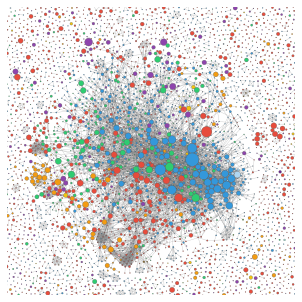

In [477]:
network_G, _ = nw.visualize(G, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G)
# plt.savefig("network_figures/G.pdf")

#### Properties
Calculate basic statistics for the network

In [222]:
print(f'Number of Nodes: {G.number_of_nodes()}')
print(f'Number of Links: {G.number_of_edges()}')
print(f'Density: {nx.density(G):.5f}')
print(f'Avg. clustering: {nx.average_clustering(G):.2f}')
degrees = list(dict(G.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 7854
Number of Links: 6799
Density: 0.00022
Avg. clustering: 0.16
Average degrees: 1.73
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 108


From these basic statistics we see that the number of nodes in the networks is 7854 and the number of links is 6799. 

The density of an undirected graph is given by:

\begin{align}
d=\frac{2m}{n(n-1)},
\end{align}

where $m$ is the number of edges and $n$ is the number of nodes. The interpretation of the measure is, that the density is 0 for a graph without edges and 1 for a completely connected graph, and is therefore a measure of how dense a graph is wrt. edge connectivity. In this case, the network has a density of 0.00022. This can be a little hard to interpret, which is why we've also calculated the average clustering coefficient, that is given by:

\begin{align}
\overline{C}=\frac{1}{N} \sum_{i=1}^N \frac{2L_i}{k_i(k_i-1)},
\end{align}

where $L_i$ is the number of links between the $k_i$ neighbours of node $i$. The interpretation of this measure is the probability that two neighbours of a randomly selected node link, to each other. For this network, we have an average clustering coefficient of 0.16.

Lastly, we see that the average degree of the nodes in the graph is 1.73, which means that a node on average is connected to 1.73 other nodes. We also see that both the minimum, median and mode of degrees is 0, whereas the maximum degree is 108.

##### Analysis of degrees
We will now analyse the degrees of the network a bit more thoroughly by looking at the distribution of degrees on a log-log scale. The reasoning for this is that a common feature for real world networks are hubs - meaning that a few nodes in a network are highly connected to other nodes. [_Scale-free networks_](https://mathinsight.org/scale_free_network) are networks with this presence of large hubs and such networks are characterised by a power-law degree distribution.

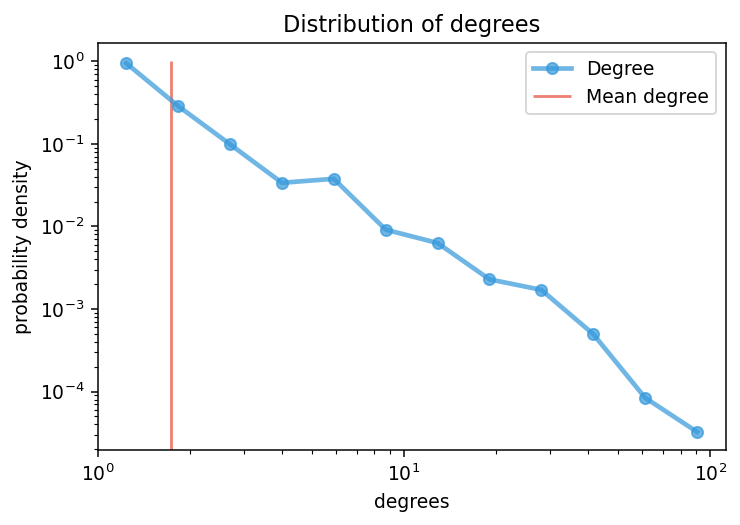

In [223]:
bins = np.logspace(0, np.log10(max(degrees)), 13)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots(dpi=135)
ax.plot(x, hist, marker='.', alpha=0.7, linewidth=2.5, markersize=12, color='#3498DB', label='Degree')
ax.vlines(np.mean(degrees), 0, 1, colors='#E74C3C', alpha=0.7, label='Mean degree')
ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
ax.legend()
ax.set_title('Distribution of degrees')
ax.set_yscale("log")
ax.set_xscale("log")

Looking at the figure above, we see exactly that the degree distribution of the network follow a power-law, which thus gives good indication that we are dealing with a real world network in comparison to a random network.

#### Community detection
In this section we will explore the communities of the network. To do this, we are looking at looking at the partition obtained when grouping the artists by their genre. This will be compared to the partition obtained using the Louvain algorithm. To get an indication of whether the two partitions are good at divising the network into modules, both of these partitions will then be juxtapositioned with random networks, based on the real network. When doing this comparison, we can see if the modularity of the two partitions are significantly different than 0.

First off, we will be getting the partitions based on the genres

In [224]:
genre_partitioning = get_partitioning(G)
genre_partitioning_dict = dict()
for partition in genre_partitioning:
    for artist, data in partition.nodes(data=True):
        genre_partitioning_dict[artist] = data['group']

print(f'Genre partitioning modularity using homemade modularity function: {modularity(G, genre_partitioning):.4f}')
print(f'Genre partitioning modularity using python-louvain modularity function: {community.modularity(genre_partitioning_dict, G):.4f}')

Genre partitioning modularity using homemade modularity function: 0.3200
Genre partitioning modularity using python-louvain modularity function: 0.3338


We will now be calculating the modularity of the network based on the partitioning obtained using the Louvain algorithm.

In [225]:
louvain_modularity = community.modularity(community.best_partition(G), G)
print(f'Modularity for the full network: {louvain_modularity:.4f}')

Modularity for the full network: 0.7440


We initially see that the modularity obtained by using the Louvain algorithm is more than twice as large as when using the genres.

##### Building randon network for comparison
Next up, we will be generating a 1000 random networks using the double edge swap algorithm. This makes it so each node in the new random network has the same degree as it had in the original networks, but the connections are different. For each of these random networks, we will be partitioning them using the genres and calculate their modularities. We do 1.2*number of edges swaps to make sure we get a fully random version of the network.

In [226]:
modularity_list = []
N = 1000
# graph = G.copy()
for i in tqdm(range(N)):
    graph = G.copy()
    RG = nx.double_edge_swap(graph, nswap=graph.number_of_edges()*1.2, max_tries=10000, seed=None)
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:34<00:00,  4.66it/s]


In [227]:
print(f'Average modularity of random networks: {np.mean(modularity_list):.4f}')
print(f'Standard deviation of modularity of random networks: {np.std(modularity_list):.4f}')

Average modularity of random networks: 0.0256
Standard deviation of modularity of random networks: 0.0048


We see that the mean and standard deviation of the modularity is 0, which is to be expected, as the networks are random, and we therefore shouldn't have any good partition using the genres.

To get an overview of the genre partition and the Louvain algorithm partition, we will now plot the distribution of the configuration model's modularity along side the genre partition's modularity and the Louvain algorithm partition's modularity.

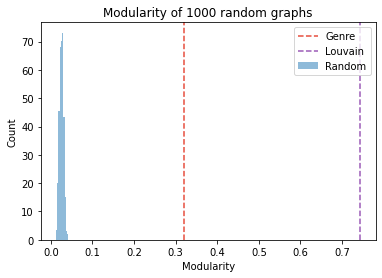

In [228]:
plt.hist(modularity_list, bins=10, alpha=0.5, label='Random', density=True)
plt.axvline(modularity(G, genre_partitioning), color = '#E74C3C', linestyle='--', label='Genre')
plt.axvline(louvain_modularity, color = '#9B59B6', linestyle='--', label='Louvain')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.show()

Looking at the figure above, we see that both of the partitioning methods leads to a modularity significantly different from 0, and thereby also larger than any of those from the random networks. Through the modularity measure, we can thus deem that the network is not random. Though, as touched upon previously, the modularity of the networks partitioned using the Louvain algorithm is more than twice the size of genre partition. To get an understanding of how this partition looks, we will be visualising the graph with the Louvain partitioning.

In [229]:
G_louvain_partition = community.best_partition(G)
G_louvain = G.copy()
for artist, data in G_louvain.nodes(data=True):
    data['group'] = G_louvain_partition[artist]

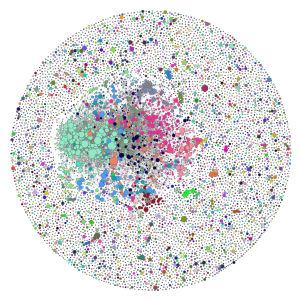

In [180]:
network_G_louvain, _ = nw.visualize(G_louvain, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_louvain)

Noticeable here is that the Louvain algorithm actually also groups many of the rap, pop, rock and country artists together into four separate groups, though in general also a lot more groups are seen. Let's see just how many groups:

In [230]:
print(f'Number of groups using genres: {len(set(data["group"] for art, data in G.nodes(data=True)))}')
print(f'Number of groups using Louvain: {max(G_louvain_partition.values())+1}')

Number of groups using genres: 20
Number of groups using Louvain: 4994


We here see that the Louvain algorithm partitions the network into an immense 4994 groups, which is enormous compared to the 7854 nodes in the graph. An explanation for this is that the large number of singleton nodes are probably given their own group, which gives a good partitioning, but doesn't make much sense compared to a partitioning using genres.

#### Betweenness centrality
As mentioned previously, we have decided to weigh the nodes in the network with the number of songs that artist has in the data set. The advantage of this, is that the most popular artists will be the ones that are easiest to see, this is especially the case for older artists that haven't collaborated as much - such as Elvis Presley or The Beatles. Artists like these would be virtually invisible if we would have weighted the nodes by the strength of their connections. Though, weighing nodes by the strength of their connections tell a great deal about which nodes are the biggest collaborators, and thereby some of the most central nodes in the graph.

We will therefore in this section deal with [_betweenness centrality_](https://en.wikipedia.org/wiki/Betweenness_centrality) that, for each node in a graph, is a measure of how central that node is. The measure is based on shortest paths in such a way that the betweenness centrality for each node is the number of shortest paths that pass through the node. The formula for betweenness centrality is given by:

\begin{align}
BC(n)=\sum_{s\neq v \neq t} \frac{\sigma_{s,t}(n)}{\sigma_{s,t}},
\end{align}

where $\sigma_{s,t}$ is the total number of shortest paths from node $s$ to node $t$ and $\sigma_{s,t}(n)$ is the number of those paths that pass through $n$.

Combining this with weighing the artists by the number of songs they have in the data set will give us a great overview of not just the most popular artists, but also the most central, collaboratory and connective artists.

In [479]:
bc = nx.betweenness_centrality(G)
sorted_bc = {k: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}
{k:v for k, v in list(sorted_bc.items())[:20]}

{'lil wayne': 0.005317744986935318,
 'kanye west': 0.00477732194703584,
 'drake': 0.0040992952383548,
 'nicki minaj': 0.00372998562506935,
 'chris brown': 0.003497182027077851,
 'quincy jones': 0.0033407921327571347,
 'snoop dogg': 0.0032804643884809617,
 'ludacris': 0.0032057762687176007,
 'mariah carey': 0.0029498104582908087,
 'jay-z': 0.0027964731321757533,
 'usher': 0.0027923306315446577,
 'james ingram': 0.002375229131480285,
 't.i.': 0.00230179456235995,
 'stevie wonder': 0.002269109973940989,
 'travis scott': 0.0022514208494022435,
 'eminem': 0.0020636677383667206,
 'mary j. blige': 0.0019665122776432063,
 'll cool j': 0.001955460879139131,
 'janet jackson': 0.0019285287431289057,
 'dionne warwick': 0.0018724977713530553}

Having calculated the betweenness centrality for each node, we see that many rappers are present in the top-20. This is not too surprising given the the number of rap artists, their tendency to collaborate and the graph we were looking at earlier. Though we also see names like Quincy Jones, James Ingram and Stevie Wonder - it is interesting to see those artists playing a central part in the network.

### Without singletons
The next part of the analysis for the full network is the version where we will be removing singleton nodes with less than 5 songs. The following section will go through the same steps as for the complete network, so not everything will be described with the same level of detail.

In [232]:
G_no_singles = G.copy()
for artist, data in G.nodes(data=True):
    if G_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_no_singles.remove_node(artist)

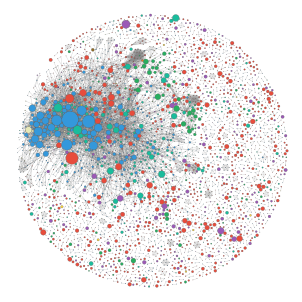

In [204]:
network_G_no_singles, _ = nw.visualize(G_no_singles, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_no_singles)
# plt.savefig("network_figures/G_no_singles.pdf")

#### Properties
Calculate basic statistics for the network

In [233]:
graph = G_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 4154
Number of Links: 6799
Density: 0.00079
Avg. clustering: 0.30
Average degrees: 3.27
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 108


Compared to the full network, we have now gone down from 7854 to 4154 nodes while keeping the same number of edges. As expected, all the other network properties have gone up, meaning that with a larger density, avg. clustering and average degrees, we should now see a network that is more densely connected.

##### Analysis of degrees

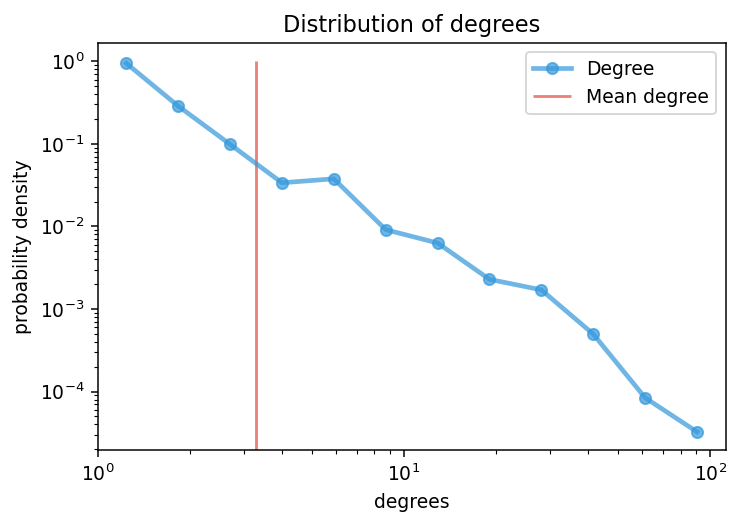

In [234]:
bins = np.logspace(0, np.log10(max(degrees)), 13)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots(dpi=135)
ax.plot(x, hist, marker='.', alpha=0.7, linewidth=2.5, markersize=12, color='#3498DB', label='Degree')
ax.vlines(np.mean(degrees), 0, 1, colors='#E74C3C', alpha=0.7, label='Mean degree')
ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
ax.legend()
ax.set_title('Distribution of degrees')
ax.set_yscale("log")
ax.set_xscale("log")

Looking at the figure above, we again see that the degree distribution follow a power-law.

#### Community detection
We will again communities of the network using both the genres and the Louvain algorithm, both of which will be compared to random networks.

First off, we will be getting the partitions based on the genres.

In [235]:
genre_partitioning = get_partitioning(G_no_singles)
genre_partitioning_dict = dict()
for partition in genre_partitioning:
    for artist, data in partition.nodes(data=True):
        genre_partitioning_dict[artist] = data['group']

print(f'Genre partitioning modularity using homemade modularity function: {modularity(G_no_singles, genre_partitioning):.4f}')
print(f'Genre partitioning modularity using python-louvain modularity function: {community.modularity(genre_partitioning_dict, G_no_singles):.4f}')

Genre partitioning modularity using homemade modularity function: 0.3200
Genre partitioning modularity using python-louvain modularity function: 0.3338


We here see a modularity that is exactly the same as before. The formula for the modularity is given by [(cf. eq, 9.12 of the NS book)](http://networksciencebook.com/chapter/9#modularity):

\begin{align}
M= \sum_{c=1}^{n_c}\left\lfloor \frac{L_c}{L}-\left(\frac{k_c}{2L} \right)^2 \right\rfloor
\end{align}

Where $n_c$ is the number of communities, $L_c$ is the number of links in community $c$, $L$ is the total number of links in the network and $k_c$ is the total degree of community $c$. This therefore means, that the modularity doesn't depend at all on the number of nodes, and since these are the only things removed from the full network, the modularity doesn't change.

We will now be calculating the modularity of the network based on the partitioning obtained using the Louvain algorithm.

In [236]:
louvain_modularity = community.modularity(community.best_partition(G_no_singles), G_no_singles)
print(f'Modularity for the full network: {louvain_modularity:.4f}')

Modularity for the full network: 0.7478


We initially see that the modularity obtained by using the Louvain algorithm is almost the same as for the full network (0.7440). This is due to the Louvain algorithm not being fully optimal and non-deterministic. So as for the full graph, the modularity of the Louvain partition is more than twice the size of the genre partition.

##### Building randon network for comparison
Next up, we will be generating a 1000 random networks using the double edge swap algorithm. For each of these random networks, we will be partitioning them using the genres and calculate their modularities.

In [237]:
modularity_list = []
N = 1000
for i in tqdm(range(N)):
    graph = G_no_singles.copy()
    RG = nx.double_edge_swap(graph, nswap=graph.number_of_edges()*1.2, max_tries=10000, seed=None)
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:44<00:00,  6.09it/s]


In [238]:
print(f'Average modularity of random networks: {np.mean(modularity_list):.4f}')
print(f'Standard deviation of modularity of random networks: {np.std(modularity_list):.4f}')

Average modularity of random networks: 0.0256
Standard deviation of modularity of random networks: 0.0049


We see that the mean and standard deviation of the modularity is 0, which is to be expected, as the networks are random, and we therefore shouldn't have any good partition using the genres.

To get an overview of the genre partition and the Louvain algorithm partition, we will now plot the distribution of the configuration model's modularity along side the genre partition's modularity and the Louvain algorithm partition's modularity.

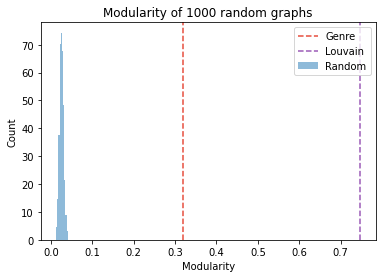

In [239]:
plt.hist(modularity_list, bins=10, alpha=0.5, label='Random', density=True)
plt.axvline(modularity(G_no_singles, genre_partitioning), color = '#E74C3C', linestyle='--', label='Genre')
plt.axvline(louvain_modularity, color = '#9B59B6', linestyle='--', label='Louvain')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.show()

Looking at the figure above, we see that both of the partitioning methods leads to a modularity significantly different from 0, and thereby also larger than any of those from the random networks. Though, as touched upon previously, the modularity of the networks partitioned using the Louvain algorithm is more than twice the size of genre partition. To get an understanding of how this partition looks, we will be visualising the graph with the Louvain partitioning.

In [240]:
G_no_singles_louvain_partition = community.best_partition(G_no_singles)
G_no_singles_louvain = G_no_singles.copy()
for artist, data in G_no_singles_louvain.nodes(data=True):
    data['group'] = G_no_singles_louvain_partition[artist]

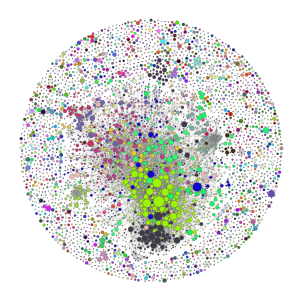

In [72]:
network_G_no_singles_louvain, _ = nw.visualize(G_no_singles_louvain, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_no_singles_louvain)

As with the previous Louvain graph, the algorithm manages to group the main clumps of nodes together quite well. Though noticible is, that the rappers are divided into two groups (light green and black).

Let's see how many groups we have in this partitioning:

In [241]:
print(f'Number of groups using genres: {len(set(data["group"] for art, data in G_no_singles.nodes(data=True)))}')
print(f'Number of groups using Louvain: {max(G_no_singles_louvain_partition.values())+1}')

Number of groups using genres: 20
Number of groups using Louvain: 1293


We here see that the Louvain algorithm partitions the network into an 1293 groups, which is a lot less compared to the 4992 of the last Louvain network. This means that the number of communities is reduced by 4994 - 1293 = 3701 and having lost 7854 - 4154 = 3700 nodes when removing singletons, it is confirmed, that the Louvain algorithm gives all singleton nodes their own community.

Having now examined the full network for all genres for the musical artists, we will be moving on to analysing some of the most popular genres that we think are interesting.

## Pop network

Were here looking at the network of artists who has at least one song with the tag _pop_ in the data set. The size of the nodes will be determined by the number of songs they have with the tag _pop_.

In [242]:
genre = 'pop'
G_pop = get_network_by_genre(G, genre)
for artist, data in G_pop.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

### With singletons

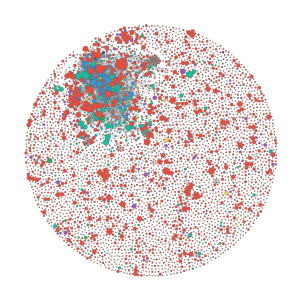

In [317]:
network_G_pop, _ = nw.visualize(G_pop, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_pop)
# plt.savefig("network_figures/G.pdf")

#### Properties
Calculate basic statistics for the network

In [243]:
graph = G_pop
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 4802
Number of Links: 3907
Density: 0.00034
Avg. clustering: 0.10
Average degrees: 1.63
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 74


In comparison to the full network, the pop network has approximately 3000 fewer nodes, 2900 fewer links, but the density, average clustering and average degree hasn't changes all that much.

#### Community detection
In this section we will explore the communities of the pop network. We will go through the same steps as previously.
First off, we will be getting the partitions based on the genres

In [244]:
genre_partitioning = get_partitioning(G_pop)
genre_partitioning_dict = dict()
for partition in genre_partitioning:
    for artist, data in partition.nodes(data=True):
        genre_partitioning_dict[artist] = data['group']

print(f'Genre partitioning modularity using homemade modularity function: {modularity(G_pop, genre_partitioning):.4f}')
print(f'Genre partitioning modularity using python-louvain modularity function: {community.modularity(genre_partitioning_dict, G_pop):.4f}')

Genre partitioning modularity using homemade modularity function: 0.2321
Genre partitioning modularity using python-louvain modularity function: 0.2830


We here see a modularity which is lower than what it was for the full network.

We will now be calculating the modularity of the network based on the partitioning obtained using the Louvain algorithm.

In [245]:
louvain_modularity = community.modularity(community.best_partition(G_pop), G_pop)
print(f'Modularity for the full network: {louvain_modularity:.4f}')

Modularity for the full network: 0.7053


Louvain partition modularity is seen to be quite a lot large than the genre modularity.

##### Building randon network for comparison
Next up, we will be generating a 1000 random networks using the double edge swap algorithm. For each of these random networks, we will be partitioning them using the genres and calculate their modularities.

In [246]:
modularity_list = []
N = 1000
for i in tqdm(range(N)):
    graph = G_pop.copy()
    RG = nx.double_edge_swap(graph, nswap=graph.number_of_edges()*1.2, max_tries=10000, seed=None)
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.72it/s]


In [247]:
print(f'Average modularity of random networks: {np.mean(modularity_list):.4f}')
print(f'Standard deviation of modularity of random networks: {np.std(modularity_list):.4f}')

Average modularity of random networks: 0.0161
Standard deviation of modularity of random networks: 0.0065


We see that the mean and standard deviation of the modularity is 0, which is to be expected, as the networks are random, and we therefore shouldn't have any good partition using the genres.

To get an overview of the genre partition and the Louvain algorithm partition, we will now plot the distribution of the configuration model's modularity along side the genre partition's modularity and the Louvain algorithm partition's modularity.

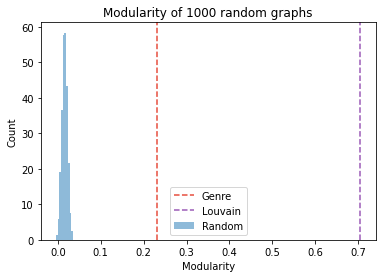

In [248]:
plt.hist(modularity_list, bins=10, alpha=0.5, label='Random', density=True)
plt.axvline(modularity(G_pop, genre_partitioning), color = '#E74C3C', linestyle='--', label='Genre')
plt.axvline(louvain_modularity, color = '#9B59B6', linestyle='--', label='Louvain')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.show()

Looking at the figure above, we see that both of the partitioning methods leads to a modularity significantly different from 0, and thereby also larger than any of those from the random networks. Though, as touched upon previously, the modularity of the network partitioned using the Louvain algorithm is much larger than using the genre partition. To get an understanding of how this partition looks, we will be visualising the graph with the Louvain partitioning.

In [249]:
G_pop_louvain_partition = community.best_partition(G_pop)
G_pop_louvain = G_pop.copy()
for artist, data in G_pop_louvain.nodes(data=True):
    data['group'] = G_pop_louvain_partition[artist]

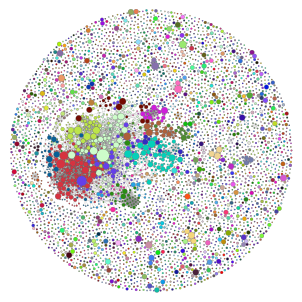

In [95]:
network_G_pop_louvain, _ = nw.visualize(G_pop_louvain, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_pop_louvain)

Noticeable here is that the Louvain algorithm manages to divide the pop artists into communities that makes decent sense. E.g. some of the rappers and R&B artists are grouped as red nodes, whereas female artists like Taylor swift are seen in very light green and other artists like Beyoncé and Rihanna in light green. Very interesting.

Let's see communities we have in total:

In [250]:
print(f'Number of groups using genres: {len(set(data["group"] for art, data in G_pop.nodes(data=True)))}')
print(f'Number of groups using Louvain: {max(G_pop_louvain_partition.values())+1}')

Number of groups using genres: 20
Number of groups using Louvain: 3328


We here see that the Louvain algorithm partitions the network into 3328 groups, which is quite a lot compared to the 4802 nodes in the graph. Again, the large number of singleton nodes is likely the explanation.

### Without singletons
This then brings us on to the next analysis for the full network; the version where we will be removing singleton nodes with less than 5 songs. The following section will go through the same steps as as previously.

In [312]:
G_pop_no_singles = G_pop.copy()
for artist, data in G_pop.nodes(data=True):
    if G_pop_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_pop_no_singles.remove_node(artist)

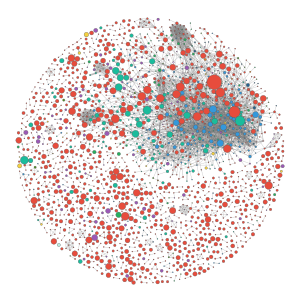

In [318]:
network_G_pop_no_singles, _ = nw.visualize(G_pop_no_singles, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_pop_no_singles)
# plt.savefig("network_figures/G_no_singles.pdf")

#### Properties
Calculate basic statistics for the network

In [252]:
graph = G_pop_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 2218
Number of Links: 3907
Density: 0.00159
Avg. clustering: 0.22
Average degrees: 3.52
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 74


Compared to the full network, we have now gone down from 4802 to 2218 nodes while keeping the same number of edges. As expected, all the other network properties have gone up, meaning that with a larger density, avg. clustering and average degrees, we should now see a network that is more densely connected.

#### Community detection
We will again communities of the network using both the genres and the Louvain algorithm, both of which will be compared to random networks.

First off, we will be getting the partitions based on the genres.

In [253]:
genre_partitioning = get_partitioning(G_pop_no_singles)
genre_partitioning_dict = dict()
for partition in genre_partitioning:
    for artist, data in partition.nodes(data=True):
        genre_partitioning_dict[artist] = data['group']

print(f'Genre partitioning modularity using homemade modularity function: {modularity(G_pop_no_singles, genre_partitioning):.4f}')
print(f'Genre partitioning modularity using python-louvain modularity function: {community.modularity(genre_partitioning_dict, G_pop_no_singles):.4f}')

Genre partitioning modularity using homemade modularity function: 0.2321
Genre partitioning modularity using python-louvain modularity function: 0.2830


We will now be calculating the modularity of the network based on the partitioning obtained using the Louvain algorithm.

In [254]:
louvain_modularity = community.modularity(community.best_partition(G_pop_no_singles), G_pop_no_singles)
print(f'Modularity for the full network: {louvain_modularity:.4f}')

Modularity for the full network: 0.7088


We initially see that the modularity obtained by using the Louvain algorithm is almost the same as for the full network (0.7053). This is due to the Louvain algorithm not being fully optimal and non-deterministic. So as for the full graph, the modularity of the Louvain partition is more than twice the size of the genre partition.

##### Building randon network for comparison
Next up, we will be generating a 1000 random networks using the double edge swap algorithm. For each of these random networks, we will be partitioning them using the genres and calculate their modularities.

In [255]:
modularity_list = []
N = 1000
for i in tqdm(range(N)):
    graph = G_pop_no_singles.copy()
    RG = nx.double_edge_swap(graph, nswap=graph.number_of_edges()*1.2, max_tries=10000, seed=None)
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.10it/s]


In [256]:
print(f'Average modularity of random networks: {np.mean(modularity_list):.4f}')
print(f'Standard deviation of modularity of random networks: {np.std(modularity_list):.4f}')

Average modularity of random networks: 0.0158
Standard deviation of modularity of random networks: 0.0065


We see that the mean and standard deviation of the modularity is 0, which is to be expected, as the networks are random, and we therefore shouldn't have any good partition using the genres.

To get an overview of the genre partition and the Louvain algorithm partition, we will now plot the distribution of the configuration model's modularity along side the genre partition's modularity and the Louvain algorithm partition's modularity.

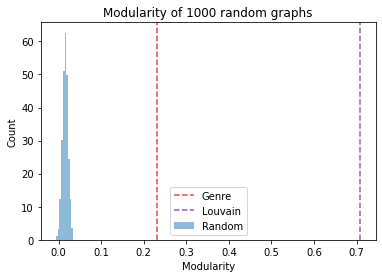

In [257]:
plt.hist(modularity_list, bins=10, alpha=0.5, label='Random', density=True)
plt.axvline(modularity(G_pop_no_singles, genre_partitioning), color = '#E74C3C', linestyle='--', label='Genre')
plt.axvline(louvain_modularity, color = '#9B59B6', linestyle='--', label='Louvain')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.show()

Looking at the figure above, we see that both of the partitioning methods leads to a modularity significantly different from 0, and thereby also larger than any of those from the random networks. Though, as touched upon previously, the modularity of the networks partitioned using the Louvain algorithm is much larger than for the genre partition. To get an understanding of how this partition looks, we will be visualising the graph with the Louvain partitioning.

In [258]:
G_pop_no_singles_louvain_partition = community.best_partition(G_pop_no_singles)
G_pop_no_singles_louvain = G_pop_no_singles.copy()
for artist, data in G_pop_no_singles_louvain.nodes(data=True):
    data['group'] = G_pop_no_singles_louvain_partition[artist]

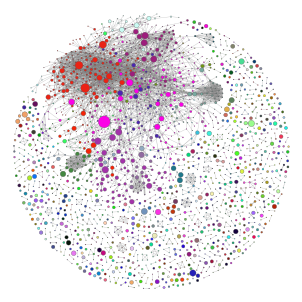

In [115]:
network_G_pop_no_singles_louvain, _ = nw.visualize(G_pop_no_singles_louvain, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_pop_no_singles_louvain)

As with the previous Louvain graph, the algorithm manages to group the main clumps of nodes together quite well.

Let's see how many groups we have in this partitioning:

In [259]:
print(f'Number of groups using genres: {len(set(data["group"] for art, data in G_pop_no_singles.nodes(data=True)))}')
print(f'Number of groups using Louvain: {max(G_pop_no_singles_louvain_partition.values())+1}')

Number of groups using genres: 19
Number of groups using Louvain: 740


We here see that the Louvain algorithm partitions the network into 740 groups, which is a lot less compared to the 3328 of the last Louvain network. This means that the number of communities is reduced by 3328 - 740 = 2588 and having lost 4802 - 2218 = 2584 nodes when removing singletons, we again see that the Louvain algorithm gives all singleton nodes their own community.

## Retrieving statistics and visualisations for the remaining genres
For the remaining genres: _rap_, _rock_, _R&B_, _country_, _soul_, _ballad_, _hip-hop_, _trap_, _singer-songwriter_ and _funk_, we will be gathering statistics and be making visualisations of the networks with and without singletons with the genre community partition and the Louvain community partition, as this information will be used on the website. Though these results will not be shown here in the notebook, as it would simply take up way too much space.

The following function takes in a genre and a graph -> computes and saves statistics and network graph visualisation for both the genre partition and the Louvain partition for the graph with and without singletons. 

In [524]:
def save_all_networks(genre, G):
    """ -------------------------- With singletons -------------------------- """
    # Get network for specified genre
    if genre == 'all':
        G_genre = G
    else:
        G_genre = get_network_by_genre(G, genre)
        for artist, data in G_genre.nodes(data=True):
            data['size'] = artist_genres_count[artist][genre]
        
    # Visualise network
    network_G_genre, config_genre = nw.visualize(G_genre, config=config, plot_in_cell_below=False)
    network_G_genre_data = nx.node_link_data(G_genre)
    
    size_map = {node['id']: node['size'] for node in network_G_genre_data['nodes']}
    for node in network_G_genre['nodes']:
        node['size'] = size_map[node['id']]
    
    # Make folder and save network and config
    filepath = f'../content/networks/{genre}/withsingles/genre'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    with open(f'../content/networks/{genre}/withsingles/genre/network.json', 'w') as fp:
        json.dump(network_G_genre, fp)
    with open(f'../content/networks/{genre}/withsingles/genre/config.json', 'w') as fp:
        json.dump(config_genre, fp)

    # Get statistics for network and save in folder
    stats_genre = dict()
    degrees = list(dict(G_genre.degree()).values())
    stat_names = ["Number of nodes", "Number of links", "Denisty", 
                  "Average clustering", "Average degree", "Max degree"]
    stat_vals = [G_genre.number_of_nodes(), G_genre.number_of_edges(), round(nx.density(G_genre),5), 
                 round(nx.average_clustering(G_genre), 2), round(np.mean(degrees), 2), max(degrees)]
    for name, val in zip(stat_names, stat_vals):
        stats_genre[name] = val
    
    # Calculate top-10 betweenness centrality
    bc = nx.betweenness_centrality(G_genre)
    sorted_bc = {k: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}
    sorted_bc_top10 = {k: round(v, 4) for k, v in list(sorted_bc.items())[:10]}
    stats_genre['Betweenness centrality'] = sorted_bc_top10
    
    with open(f'../content/networks/{genre}/withsingles/genre/stats.json', 'w') as fp:
        json.dump(stats_genre, fp)
        
    """ -------------------------- With singletons Louvain -------------------------- """
    # Get Louvain partitioning
    G_louvain_partition = community.best_partition(G_genre)
    G_louvain = G_genre.copy()
    for artist, data in G_louvain.nodes(data=True):
        data['group'] = G_louvain_partition[artist]
    
    # Visualise network
    network_G_louvain, config_louvain = nw.visualize(G_louvain, config=config, plot_in_cell_below=False)
    network_G_louvain_data = nx.node_link_data(G_louvain)
    
    size_map = {node['id']: node['size'] for node in network_G_louvain_data['nodes']}
    for node in network_G_louvain['nodes']:
        node['size'] = size_map[node['id']]

    # Make folder and save network and config
    filepath = f'../content/networks/{genre}/withsingles/louvain'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    with open(f'../content/networks/{genre}/withsingles/louvain/network.json', 'w') as fp:
        json.dump(network_G_louvain, fp)
    with open(f'../content/networks/{genre}/withsingles/louvain/config.json', 'w') as fp:
        json.dump(config_louvain, fp)
    with open(f'../content/networks/{genre}/withsingles/louvain/stats.json', 'w') as fp:
        json.dump(stats_genre, fp)
    
    
    """ -------------------------- Without singletons -------------------------- """
    ## Make networks without singletons with less than 5 songs
    G_genre_no_singles = G_genre.copy()
    for artist, data in G_genre.nodes(data=True):
        if G_genre_no_singles.degree(artist) == 0 and data['size'] < 5:
            G_genre_no_singles.remove_node(artist)
    
    # Visualise network
    network_G_genre_no_singles, config_genre_no_singles = nw.visualize(G_genre_no_singles, config=config, plot_in_cell_below=False)
    network_G_genre_no_singles_data = nx.node_link_data(G_genre_no_singles)
    
    size_map = {node['id']: node['size'] for node in network_G_genre_no_singles_data['nodes']}
    for node in network_G_genre_no_singles['nodes']:
        node['size'] = size_map[node['id']]

    
    # Make folder and save network and config
    filepath = f'../content/networks/{genre}/withoutsingles/genre'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    with open(f'../content/networks/{genre}/withoutsingles/genre/network.json', 'w') as fp:
        json.dump(network_G_genre_no_singles, fp)
    with open(f'../content/networks/{genre}/withoutsingles/genre/config.json', 'w') as fp:
        json.dump(config_genre_no_singles, fp)
    
    # Get statistics for network and save in folder
    stats_genre_no_singles = dict()
    degrees_no_singles = list(dict(G_genre_no_singles.degree()).values())
    stat_names = ["Number of nodes", "Number of links", "Denisty", 
                  "Average clustering", "Average degree", "Max degree"]
    stat_vals = [G_genre_no_singles.number_of_nodes(), G_genre_no_singles.number_of_edges(), round(nx.density(G_genre_no_singles),5), 
                 round(nx.average_clustering(G_genre_no_singles), 2), round(np.mean(degrees_no_singles), 2), max(degrees_no_singles)]
    for name, val in zip(stat_names, stat_vals):
        stats_genre_no_singles[name] = val
    
    # Calculate top-10 betweenness centrality
    bc = nx.betweenness_centrality(G_genre_no_singles)
    sorted_bc = {k: v for k, v in sorted(bc.items(), key=lambda item: item[1], reverse=True)}
    sorted_bc_top10 = {k: round(v, 4) for k, v in list(sorted_bc.items())[:10]}
    stats_genre_no_singles['Betweenness centrality'] = sorted_bc_top10

    with open(f'../content/networks/{genre}/withoutsingles/genre/stats.json', 'w') as fp:
        json.dump(stats_genre_no_singles, fp)
    
    """ -------------------------- Without singletons Louvain -------------------------- """
    # Get Louvain partitioning
    G_louvain_partition_no_singles = community.best_partition(G_genre_no_singles)
    G_louvain_no_singles = G_genre_no_singles.copy()
    for artist, data in G_louvain_no_singles.nodes(data=True):
        data['group'] = G_louvain_partition_no_singles[artist]
    
    # Visualise network
    network_G_louvain_no_singles, config_louvain_no_singles = nw.visualize(G_louvain_no_singles, config=config, plot_in_cell_below=False)
    network_G_louvain_no_singles_data = nx.node_link_data(G_louvain_no_singles)
    
    size_map = {node['id']: node['size'] for node in network_G_louvain_no_singles_data['nodes']}
    for node in network_G_louvain_no_singles['nodes']:
        node['size'] = size_map[node['id']]
    
    
    # Make folder and save network and config
    filepath = f'../content/networks/{genre}/withoutsingles/louvain'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    with open(f'../content/networks/{genre}/withoutsingles/louvain/network.json', 'w') as fp:
        json.dump(network_G_louvain_no_singles, fp)
    with open(f'../content/networks/{genre}/withoutsingles/louvain/config.json', 'w') as fp:
        json.dump(config_louvain_no_singles, fp)
    with open(f'../content/networks/{genre}/withoutsingles/louvain/stats.json', 'w') as fp:
        json.dump(stats_genre_no_singles, fp)

In [525]:
save_all_networks('soul', G)